# Sentinel-2 다운로드 실습: Microsoft Planetary Computer

이 노트북에서는 다음 과정을 단계별로 실습합니다.

> 참고: Planetary Computer의 공개 데이터셋은 **API 키 없이도 SAS 토큰을 받아 다운로드 가능**합니다.

In [1]:
# !pip install -U -q geopandas shapely pyproj rasterio rioxarray xarray
# !pip install -U -q pystac-client planetary-computer
# !pip install -U -q leafmap

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import planetary_computer
import requests
import rasterio
import rioxarray
import xarray as xr
import numpy as np

from shapely.geometry import box, shape
from datetime import datetime
from pystac_client import Client
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
from rasterio.transform import Affine

import warnings
warnings.filterwarnings("ignore")

### 국립공원 경계 불러오기 및 시각화

국립공원 경계 GPKG 파일을 불러와 좌표계를 확인하고, 경계선을 지도 형태로 시각화합니다.

Original CRS: EPSG:4326


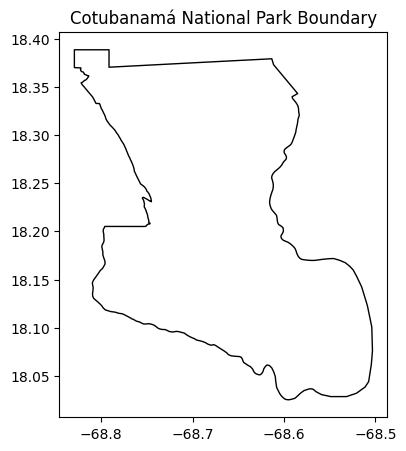

In [3]:
url = "https://raw.githubusercontent.com/osgeokr/mmarn-data-capacity-2025/main/cotubanama_np_boundary.gpkg"

gdf = gpd.read_file(url)
print("Original CRS:", gdf.crs)

ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(5, 5))
ax.set_title("Cotubanamá National Park Boundary")
plt.show()

### UTM 좌표계 추정

경계 데이터의 공간 분포를 기반으로 적절한 UTM 좌표계를 추정하여 확인합니다.

In [4]:
# UTM CRS 추정 및 확인
utm_crs = gdf.estimate_utm_crs()
print("Estimated UTM CRS:", utm_crs)

Estimated UTM CRS: EPSG:32619


### 버퍼 생성 및 Bounding Box 구축

경계 데이터를 UTM 좌표계로 변환한 후 10 km 버퍼를 생성합니다.  
생성된 버퍼를 다시 WGS84로 변환하고, 이 버퍼를 포함하는 Bounding Box를 계산해 GeoDataFrame으로 구성합니다.  
마지막으로 원본 경계, 버퍼, Bounding Box를 함께 시각화하여 공간 범위를 확인합니다.

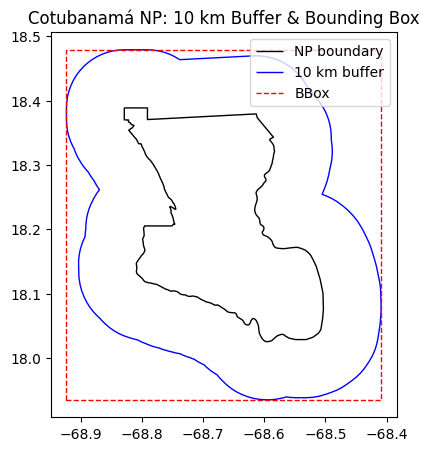

In [5]:
# UTM으로 변환
gdf_utm = gdf.to_crs(utm_crs)

# 10 km 버퍼 생성 (10,000 m)
buffer_utm = gdf_utm.buffer(10_000)

# 다시 WGS84로 변환
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_utm, crs=utm_crs).to_crs(gdf.crs)

# 버퍼의 Bounding Box 생성
minx, miny, maxx, maxy = buffer_gdf.total_bounds
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=gdf.crs)

# 시각화
fig, ax = plt.subplots(figsize=(5, 5))
gdf.boundary.plot(ax=ax, color="black", linewidth=1, label="NP boundary")
buffer_gdf.boundary.plot(ax=ax, color="blue", linewidth=1, label="10 km buffer")
bbox_gdf.boundary.plot(ax=ax, color="red", linestyle="--", linewidth=1, label="BBox")

ax.set_title("Cotubanamá NP: 10 km Buffer & Bounding Box")
ax.legend()
plt.show()

### Sentinel-2 STAC 검색

Planetary Computer STAC API를 사용하여 지정한 Bounding Box 중심점, 기간, 구름량 조건에 맞는 Sentinel-2 L2A 영상을 검색합니다.  
검색 결과 중 구름량이 가장 낮고 날짜가 빠른 장면을 선택하여 반환합니다.

In [6]:
def search_sentinel2_planet_computer(bbox_gdf, time_range, max_cloud=20):
    # bbox_gdf
    center = bbox_gdf.geometry.union_all().centroid
    center_geojson = center.__geo_interface__

    # Planetary Computer STAC 연결
    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    # STAC 검색
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=center_geojson,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": max_cloud}},
    )
    
    items = list(search.items())
    if not items:
        print(f"[INFO] 조건을 충족하는 Sentinel-2 영상이 없습니다. "
              f"(구름량 < {max_cloud}%, 기간 = {time_range})")
        return None
    
    # 구름량 → 날짜 순으로 정렬
    def sort_key(item):
        cloud = item.properties.get("eo:cloud_cover", 100)
        dt = item.datetime or datetime.max
        return (cloud, dt)

    return sorted(items, key=sort_key)[0]

### Sentinel-2 미리보기 이미지 표시

STAC Item에서 제공하는 `rendered_preview` 또는 `thumbnail` 자산을 찾은 뒤 원격에서 다운로드하여 메모리로 로드하고, RGB 이미지로 변환해 화면에 표시합니다.  
해당 장면의 ID, 날짜, 구름량 정보를 제목으로 함께 출력합니다.

In [7]:
def show_sentinel2_preview(item):
    if item is None:
        print("[WARN] item이 None입니다. 검색 결과를 확인하세요.")
        return
    # preview asset 선택
    if "rendered_preview" in item.assets:
        asset = item.assets["rendered_preview"]
    elif "thumbnail" in item.assets:
        asset = item.assets["thumbnail"]
    else:
        raise ValueError("preview asset 없음")

    # 원격 이미지 다운로드
    r = requests.get(asset.href)
    r.raise_for_status()

    # rasterio로 메모리에서 읽기
    with MemoryFile(r.content) as memfile:
        with memfile.open() as src:
            img = src.read()  # (3, H, W)
            img_plot = img.transpose((1, 2, 0))  # RGB

    # 렌더링
    plt.figure(figsize=(6, 6))
    plt.imshow(img_plot)
    plt.axis("off")
    plt.title(
        f"{item.id}\n"
        f"{item.datetime.date()} | Cloud: {item.properties.get('eo:cloud_cover', 'NA')}%"
    )
    plt.show()

### Sentinel-2 장면 검색 및 미리보기

지정한 기간과 구름량 조건으로 Sentinel-2 장면을 검색하고, 선택된 장면의 미리보기 이미지를 화면에 표시합니다.

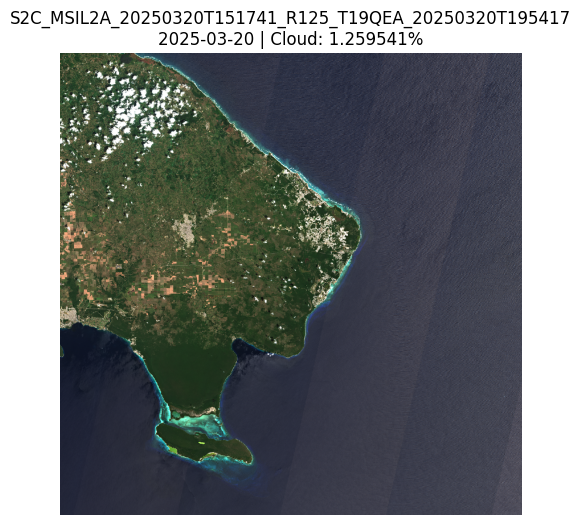

In [8]:
time_range = "2025-01-01/2025-10-31"
item = search_sentinel2_planet_computer(bbox_gdf, time_range, max_cloud=10)
show_sentinel2_preview(item)

### Sentinel-2 장면 영역과 분석 영역 비교 시각화

선택된 Sentinel-2 장면의 공간 범위를 GeoDataFrame으로 변환하여, Bounding Box 및 국립공원 경계와 함께 지도 위에 표시해 공간적 관계를 확인합니다.

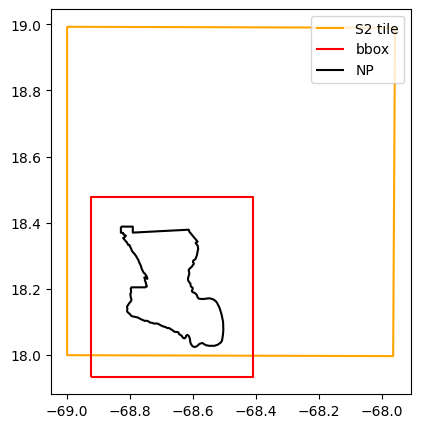

In [9]:
s2_geom = shape(item.geometry)
s2_gdf = gpd.GeoDataFrame(geometry=[s2_geom], crs="EPSG:4326")

ax = s2_gdf.boundary.plot(color="orange", figsize=(5, 5), label="S2 tile")
bbox_gdf.boundary.plot(ax=ax, color="red", label="bbox")
gdf.boundary.plot(ax=ax, color="black", label="NP")
ax.legend()
plt.show()

### Sentinel-2 밴드 다운로드 및 클리핑

STAC Item에서 지정된 밴드들을 순차적으로 다운로드한 뒤, 분석용 Bounding Box 영역으로 클리핑하여 개별 GeoTIFF 파일로 저장합니다.  
저장된 밴드들을 메모리에서 하나의 스택으로 결합하여 반환합니다.

In [10]:
def download_sentinel2_bands(item, bands, bbox_gdf, out_tif):
    """
    item: STAC item
    bands: ["B02","B03","B04"] 등
    bbox_gdf: EPSG:4326
    out_tif: 출력 파일 접두어(prefix)
    """
    das = []

    for b in bands:
        print(f"[INFO] {b} 다운로드 및 클리핑 중...")

        href = item.assets[b].href
        da = rioxarray.open_rasterio(href, masked=True).squeeze()

        # bbox를 래스터 CRS로 변환
        bbox_proj = bbox_gdf.to_crs(da.rio.crs)
        minx, miny, maxx, maxy = bbox_proj.total_bounds

        da_clip = da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
        da_clip.name = b
        das.append(da_clip)

        # 개별 밴드 파일명 구성 (접두어 + 밴드명)
        out_file = f"{out_tif}{b.lower()}.tif"

        # GeoTIFF 저장
        da_clip.rio.to_raster(out_file)

        # rasterio로 밴드 이름 설정
        with rasterio.open(out_file, "r+") as dst:
            dst.set_band_description(1, b)

        print(f"[INFO] 저장 완료: {out_file}")

    # 메모리에서 스택 생성
    stack = xr.concat(das, dim="band")
    stack = stack.assign_coords(band=bands)

    print("[INFO] 모든 밴드 다운로드 및 저장 완료")

    return stack

In [11]:
bands = ["B02", "B03", "B04"]
stack = download_sentinel2_bands(item, bands, bbox_gdf, "sentinel2_")

[INFO] B02 다운로드 및 클리핑 중...
[INFO] 저장 완료: sentinel2_b02.tif
[INFO] B03 다운로드 및 클리핑 중...
[INFO] 저장 완료: sentinel2_b03.tif
[INFO] B04 다운로드 및 클리핑 중...
[INFO] 저장 완료: sentinel2_b04.tif
[INFO] 모든 밴드 다운로드 및 저장 완료


### 밴드 스택을 단일 GeoTIFF로 저장

메모리에서 구성된 밴드 스택을 기반으로 GeoTIFF 메타데이터를 설정하고, 각 밴드를 지정된 이름으로 기록하여 하나의 멀티밴드 GeoTIFF 파일로 저장합니다.

In [12]:
def save_stack_as_tif(stack, bands, out_file):
    """
    stack: xr.DataArray (shape: [band, y, x])
    bands: ["B02","B03","B04"] 등 밴드 이름 리스트
    out_file: 저장할 tif 파일명 (예: "sentinel-2_rgb.tif")
    """

    # 메타데이터 가져오기
    height, width = stack.shape[1], stack.shape[2]
    transform = stack.rio.transform()
    crs = stack.rio.crs

    # rasterio 프로파일 생성
    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": len(bands),
        "dtype": stack.dtype,
        "crs": crs,
        "transform": transform,
    }

    # 파일 저장
    with rasterio.open(out_file, "w", **profile) as dst:
        for i, b in enumerate(bands, start=1):
            dst.write(stack.sel(band=b).values, i)
            dst.set_band_description(i, b)

    print(f"[INFO] 스택 저장 완료: {out_file}")

In [13]:
bands = ["B02", "B03", "B04"]
save_stack_as_tif(stack, bands, "sentinel2_rgb.tif")

[INFO] 스택 저장 완료: sentinel2_rgb.tif


### 저장된 GeoTIFF를 스트레치 후 시각화

GeoTIFF에서 선택한 밴드를 이름 기준으로 추출한 뒤, 각 밴드에 2–98% 구간 스트레치를 적용하여 단일 밴드 또는 다중 밴드 이미지로 시각화합니다.

In [14]:
def show_tif(tif_path, band_names):
    """
    GeoTIFF에서 지정된 밴드를 스트레치 후 시각화
    band_names 예: ["B04","B03","B02"] (RGB)
    """

    with rasterio.open(tif_path) as src:
        img = src.read()                      # (bands, H, W)
        desc = list(src.descriptions)         # 저장된 밴드 이름

    # 밴드 이름 → 인덱스 매핑
    band_indices = []
    for name in band_names:
        if name not in desc:
            raise ValueError(f"'{name}' 밴드를 GeoTIFF에서 찾을 수 없음")
        band_indices.append(desc.index(name))

    selected = img[band_indices, :, :]

    # 2–98% 스트레치
    def stretch(arr):
        p2 = np.percentile(arr, 2)
        p98 = np.percentile(arr, 98)
        arr_clip = np.clip(arr, p2, p98)
        return (arr_clip - p2) / (p98 - p2 + 1e-6)

    # 단일 밴드
    if selected.shape[0] == 1:
        stretched = stretch(selected[0])
        plt.figure(figsize=(7,7))
        plt.imshow(stretched, cmap='gray')
        plt.axis("off")
        plt.title(f"{tif_path}\nBand: {band_names[0]}")
        plt.show()

    # 다중 밴드 (RGB 등)
    else:
        stretched_bands = [stretch(selected[i]) for i in range(selected.shape[0])]
        rgb = np.stack(stretched_bands, axis=-1)
        plt.figure(figsize=(6,6))
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(f"{tif_path}\nBands: {band_names}")
        plt.show()

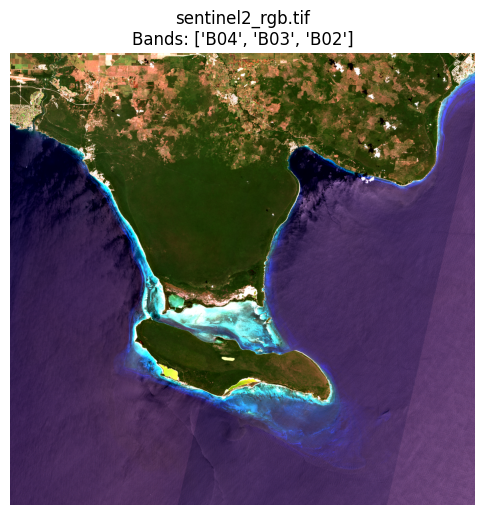

In [15]:
show_tif("sentinel2_rgb.tif", ["B04", "B03", "B02"])